In [114]:
from matplotlib import cm
from matplotlib import axes
from matplotlib import colormaps
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd 
import numpy as np 
import os
import shutil

In [ ]:
class DC_IV():

    # инициализация, проверка существования папки, проверка пустоты папки
    def __init__(self, sample: str):
        sample = str(sample)
        if not os.path.exists(sample):
            raise FileNotFoundError(f'directory \'{sample}\' is not exist')
        elif  len(os.listdir(sample)) == 0:
            raise ValueError(f'directory \'{sample}\' is empty')
        else:
            self.__sample_name = sample
            self.__sample_path = os.path.abspath(sample)
            self.__collect_full_dict()

    # самая частовстречающаяся ошибка 
    def __contact_errors(self, contact):
        if isinstance(contact, list):
            raise ValueError(f'contact value must be str or int or float, not list')
        contact = str(contact)
        if contact not in self.__contacts_list:
            raise ValueError(f'contact {contact} is not exist in {self.__sample_name}')
        return contact

    # поиск всех вложенных директорий в основной папке (поиск контактов, на которых проводились измерения)
    def __find_contacts(self) -> None:
        self.__contacts_list = []
        for i in os.listdir(self.__sample_path):
            if os.path.isdir(os.path.join(self.__sample_path, i)):
                self.__contacts_list.append(f'{i}')
        if len(self.__contacts_list) == 0:
            raise ValueError(f'\'{self.__sample_path}\' does not contain subdirectories')

    # проверка, что файл с данными типа .data (отсекаем остальные файлы, если имеются)
    def __is_data(self, data_file_path: str) -> bool:
        if data_file_path.split('.')[-1] == 'data':
            return True
        else:
            return False
        
    # создание пути из названия папок
    def __join_path(self, path_list: list[str]) -> str:
        return os.path.join(self.__sample_path, *path_list)
    
    # создает папку по запрошенному пути
    def __create_dir(self, path: str) -> None:
        if os.path.isdir(path):
            shutil.rmtree(path, ignore_errors=True)
            os.mkdir(path)
        else:
            os.mkdir(path)

    # создает градиент по двум цветам и количеству точек
    def __to_colors(self, lenght: int, start_color: str, end_color: str):
        custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", [start_color, end_color])
        colors = custom_cmap(np.linspace(0, 1, lenght))
        return colors
    
    # сбор информации о файлах, содержащих DC IV измерения в каждом контакте
    def __collect_full_dict(self) -> None:
        self.__find_contacts()
        self.__full_DC_IV_dict = {}
        for contact in self.__contacts_list:
            contact_files_list = []
            for file in os.listdir(self.__join_path([contact])):
                if self.__is_data(self.__join_path([contact, file])):
                    contact_files_list.append(file)
            if len(contact_files_list) == 0:
                continue
            contact_DC_IV_measurs = []
            for measure in contact_files_list:
                measure_path = self.__join_path([contact, measure])
                with open(measure_path) as file:
                    measur_type = file.readlines()[1]
                if 'DC IV' in measur_type:
                    contact_DC_IV_measurs.append(int(measure.replace('.data', '')))
                else:
                    continue
            self.__full_DC_IV_dict[contact] = sorted(contact_DC_IV_measurs)

    # удаление контакта или контактов из словаря с измерениями
    def delete_contacts(self, contact: str | list) -> None:
        if not isinstance(contact, list):
            contact = [contact]
        for contact in contact:
            contact = str(contact)
            if contact in self.__contacts_list:
                self.__contacts_list.remove(contact)
                del self.__full_DC_IV_dict[contact]
            else:
                print(f'contact {contact} not exist in {self.__sample_name}')

    # удаление измерений из контакта 
    def delete_measurs(self, contact: str | int, measur: list) -> None:
        contact = self.__contact_errors(contact)
        will_be_del = set([i for i in measur if type(i) == int])
        for measur in will_be_del:
            if measur in self.__full_DC_IV_dict[contact]:
                self.__full_DC_IV_dict[contact].remove(measur)

    # возвращает список DC IV измерений с одного контакта 
    def get_contact_measurs(self, contact: str | int):
        contact = self.__contact_errors(contact)
        return self.__full_DC_IV_dict[contact]

    # возврат полного словаря со всеми контактами и измерениямими 
    def get_full_dict(self)-> dict:
        return self.__full_DC_IV_dict
        
    # возвращает абсолютный путь к указанной папке
    def get_abspath(self) -> str:
        return self.__sample_path
    
    # возвращает список контактов
    def get_contacts(self) -> list:
        return self.__contacts_list
    
    # возвращает датафрейм с ВАХ конкретного измерения
    def get_single_data(self, contact: str | int, measur: int) -> pd.Series:
        contact = self.__contact_errors(contact)
        measur = str(measur) + '.data'
        data_path = self.__join_path([contact, measur])
        dataframe = pd.read_csv(data_path, 
                                delimiter='   ', 
                                skiprows=16, 
                                engine='python', 
                                header=None, 
                                encoding='ISO-8859-1').astype(np.float32)
        dataframe.rename(columns = {0: 'voltage', 1: 'current', 2: 'resistance'}, inplace=True)
        dataframe['voltage'] = pd.Series([round(i, 2) for i in dataframe['voltage']])
        return dataframe['voltage'], dataframe['current']
    
    # возвращает данные с нескольких контактов
    def get_contacts_data(self, contact: str | int | list):
        pass
        
    # вызвращает словарь со значениями токов во включенном и выключенном состоянии на основе списка измерений
    def get_on_off_current(self, contact: str | int, check_voltage: float) -> dict:
        I_on = []
        I_off = []
        I_on_off = []
        contact = self.__contact_errors(contact)
        for measur in self.__full_DC_IV_dict[contact]:
            Voltage, Current = self.get_single_data(contact, measur)
            if check_voltage not in list(Voltage):
                print(f'value V = {check_voltage} is not exist in file \'{measur}.data\' from \'{contact}\' contact')
                continue
            else:
                try:
                    a, b = Current.loc[Voltage == check_voltage]
                    I_on.append(a)
                    I_off.append(b)
                    I_on_off.append(a/b)
                except:
                    print(f'Unexpected error in file \'{measur}.data\' from \'{contact}\' folder')
                    continue
        return {'on': np.array(I_on), 'off': np.array(I_off), 'on_off': np.array(I_on_off)}
    
    # расчитывает напряжения включения и выключения у ВАХ типа ReRAM на основе списка измерений
    def get_ReRAM_on_off_voltage(self, contact: str | int, branch: str = 'both') -> np.array:
        if branch not in ['both', 'b', 'positive', 'p', 'negative', 'n']:
            raise ValueError('uncorrect branch value')
        positive_voltage_switch = []
        negative_voltage_switch = []
        contact = self.__contact_errors(contact)
        for measur in self.__full_DC_IV_dict[contact]:
            Voltage, Current = self.get_single_data(contact, measur)
            delta_V = Voltage[1] - Voltage[0]
            derivative = []
            for i in range(len(Current) -1):
                if Voltage[i + 1] - Voltage[i] != 0:
                    derivative.append((Current[i + 1] - Current[i])/(Voltage[i + 1] - Voltage[i]))
                else:
                    derivative.append((Current[i+1] - Current[i])/delta_V)
            df_deriv = pd.DataFrame([Voltage[:-1], np.abs(derivative)]).transpose()
            df_deriv.rename(columns = {'voltage': 'voltage', 'Unnamed 0': 'derivative'}, inplace=True)
            pos_voltage_deriv = df_deriv.loc[df_deriv['voltage'] > 0].reset_index(drop = True)
            neg_voltage_deriv = df_deriv.loc[df_deriv['voltage'] < 0].reset_index(drop = True)
            negative_voltage_switch.append(neg_voltage_deriv.loc[np.argmax(neg_voltage_deriv['derivative'])]['voltage'])
            positive_voltage_switch.append(pos_voltage_deriv.loc[np.argmax(pos_voltage_deriv['derivative'])]['voltage'])
        if branch == 'both' or branch == 'b':
            return {'positive_switch': positive_voltage_switch, 'negative_switch': negative_voltage_switch}
        elif branch == 'positive' or branch == 'p':
            return positive_voltage_switch
        elif branch == 'negative' or branch == 'n':
            return negative_voltage_switch
            
    # рисует одну ВАХ
    def draw_single_plot(self, contact: str | int, measur: str | int, save_path: str = None, cmap: str = 'plasma') -> None:
        contact = self.__contact_errors(contact)
        measur = str(measur)
        V, I = self.get_single_data(contact, measur)
        I = np.abs(I)
        fig, ax = plt.subplots(figsize = [10,5])
        ax.grid(which='major', linewidth = 0.6)
        ax.grid(which='minor', linewidth = 0.2)
        color = colormaps[cmap](np.linspace(0, 1, len(V)))
        segments = [([V[i], I[i]], [V[i+1], I[i+1]]) for i in range(len(V)-1)]
        line_coll = LineCollection(segments)
        line_coll.set_colors(color)
        line_coll.set_joinstyle('round')
        ax.add_collection(line_coll)
        cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['start','end'], size = 15)
        ax.autoscale_view()
        ax.set_yscale('log')
        if save_path != None:
            plt.savefig(save_path, bbox_inches = 'tight', dpi = 200)
            plt.close()

    def draw_single_line(self, ax: axes, contact: str, measur: str, **kwargs) -> axes:
        contact = self.__contact_errors(contact)
        V, I = self.get_single_data(contact, measur)
        line = ax.plot(V, I, **kwargs)
        return line

    # задает градиент для последовательности графиков
    def colorize_multiple(self, line_coll: LineCollection, start_color: str = '#ff0000', end_color: str = '#1e00ff'):
        line_coll.set_color(self.__to_colors(len(line_coll.get_segments()), start_color, end_color))

    # рисует множество данных на одном графике
    def draw_multiple_lines(self, contact: str | int, axes: axes, **kwargs):
        contact = self.__contact_errors(contact)
        data_colletcion = []
        for measur in self.__full_DC_IV_dict[contact]:
            V, I = self.get_single_data(contact, measur)
            data_colletcion.append(np.array([V, np.abs(I)]).transpose())
        line_collection = LineCollection(data_colletcion, **kwargs)
        lines = axes.add_collection(line_collection)
        axes.autoscale_view()
        return lines

    # рисует всю инфу о ReRAM переключениях из отдельного словаря
    def draw_full_ReRAM_info(self, contact: str | int, check_voltage: float, current_scale: int = 1000, bins: int = 10, start_color: str = '#ff0000', end_color: str = '#1e00ff', **kwargs):
        contact = self.__contact_errors(contact)

        I = self.get_on_off_current(contact, check_voltage)
        I_on, I_off = I['on'], I['off']
        V = self.get_ReRAM_on_off_voltage(contact)
        V_pos, V_neg = V['positive_switch'], V['negative_switch']

        fig = plt.figure(figsize=(12, 7), constrained_layout=True)
        gs = GridSpec(ncols=10, nrows=4, figure=fig)
        ax_1 = plt.subplot(gs[:4, :6])
        ax_2_1 = plt.subplot(gs[0,6:9])
        ax_2_2 = plt.subplot(gs[1,6:9])
        ax_2_3 = plt.subplot(gs[2,6:9])
        ax_2_4 = plt.subplot(gs[3,6:9])
        ax_3_1 = plt.subplot(gs[0,9])
        ax_3_2 = plt.subplot(gs[1,9])
        ax_3_3 = plt.subplot(gs[2,9])
        ax_3_4 = plt.subplot(gs[3,9])

        coll = self.draw_multiple_lines(contact, ax_1, **kwargs)
        self.colorize_multiple(coll, start_color, end_color)
        ax_1.autoscale_view()
        ax_1.set_yscale('log')
        y_major = ticker.LogLocator(numticks = 10)
        y_minor = ticker.LogLocator(subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
        ax_1.yaxis.set_major_locator(y_major)
        ax_1.yaxis.set_minor_locator(y_minor)

        ax_2_1.plot(range(len(I_on)), I_on * current_scale)
        ax_2_2.plot(range(len(I_off)), I_off * current_scale)
        ax_2_3.plot(range(len(V_pos)), V_pos)
        ax_2_4.plot(range(len(V_neg)), V_neg)

        ax_3_1.hist(I_on * current_scale, bins=bins, rwidth=0.8, edgecolor = 'k', orientation = 'horizontal')
        ax_3_1.axis('off')
        ax_3_1.set(ylim = ax_2_1.get_ylim())
        ax_3_2.hist(I_off * current_scale, bins=bins, rwidth=0.8, edgecolor = 'k', orientation = 'horizontal')
        ax_3_2.axis('off')
        ax_3_2.set(ylim = ax_2_2.get_ylim())
        ax_3_3.hist(V_pos, bins=bins, rwidth=0.8, edgecolor = 'k', orientation = 'horizontal')
        ax_3_3.axis('off')
        ax_3_3.set(ylim = ax_2_3.get_ylim())
        ax_3_4.hist(V_neg,bins=bins, rwidth=0.8,  edgecolor = 'k', orientation = 'horizontal')
        ax_3_4.axis('off')
        ax_3_4.set(ylim = ax_2_4.get_ylim())

        return (fig, ax_1, [ax_2_1, ax_2_2, ax_2_3, ax_2_4], [ax_3_1, ax_3_2, ax_3_3, ax_3_4])

In [116]:
d = DC_IV('hBN_1')

In [117]:
d.delete_measurs(16, [i for i in range(52)] + [i for i in range(101,107)] + [154,155])
I = d.get_on_off_current(16, 1)

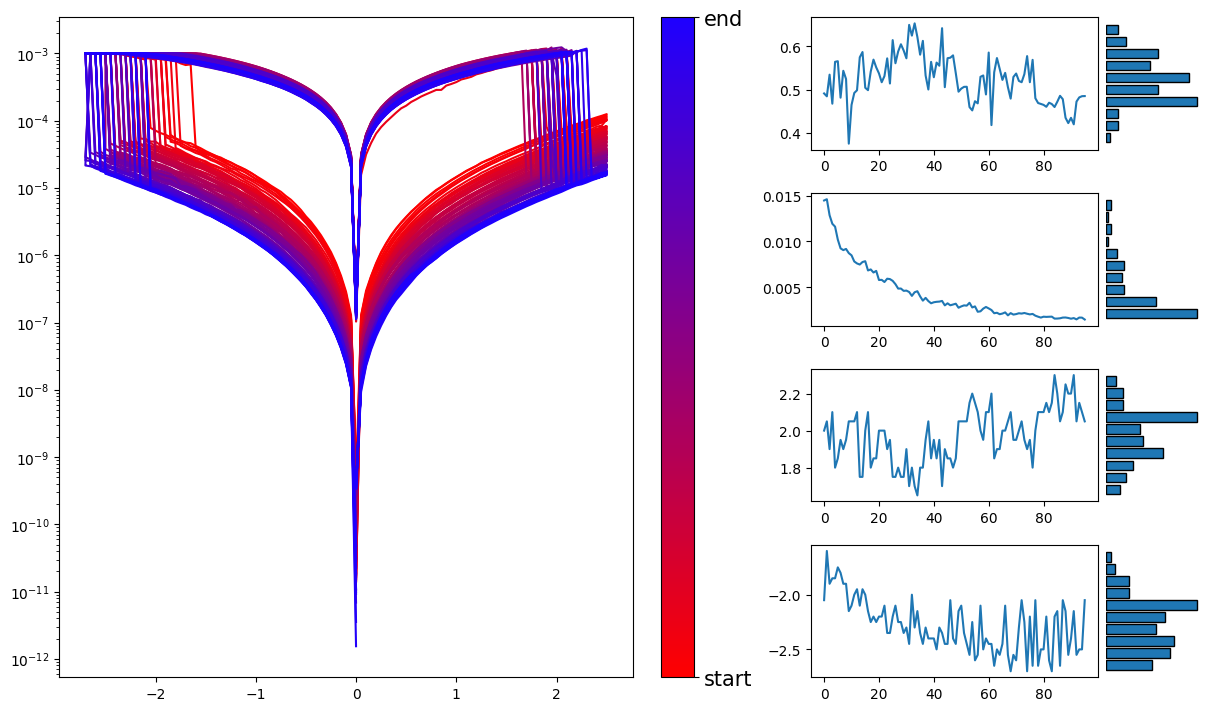

In [122]:
fig, ax, *_ = d.draw_full_ReRAM_info(16, 1)
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ['#ff0000', '#1e00ff'])
cbar = fig.colorbar(cm.ScalarMappable(cmap=custom_cmap), ax=ax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['start','end'], size = 15)